In [1]:
%matplotlib inline

import seaborn as sns
from jupyterthemes import jtplot

cmap = sns.dark_palette('azure', input='xkcd')
jtplot.style()

In [2]:
import pandas as pd

metadata = pd.read_excel('Dyslexia/subjects_phenotype.xlsx')
metadata = metadata[metadata['№ in BIDS'] != 'sub-53']
metadata

,№ in BIDS,№,Дата тестирования,Дата МРТ,пол,дата рождения,класс,Возраст,Слов за минуту,Ошибок за минуту,"Правильно ответов, доля от макс10"
0,sub-01,D_7,2019-08-30,16.09.2019,м,2008-11-21,3,10.778082,46,3,0.8
1,sub-02,D_8,2019-09-13,02.10.2019,м,2009-07-15,4,10.169863,33,0,0.8
2,sub-03,D_9,2019-09-27,04.10.2019,м,2009-05-19,3,10.364384,97,4,1.0
3,sub-04,D_10,2019-10-02,10.10.2019,м,2009-08-04,4,10.167123,38,6,0.8
4,sub-05,D_11,2019-10-02,08.10.2019,м,2010-05-26,2,9.358904,48,2,1.0
5,sub-06,D_12,2019-10-03,08.10.2019,ж,2010-05-26,3,9.361644,35,1,1.0
6,sub-07,D_13,2019-10-04,12.02.2020,м,2010-09-29,3,9.019178,76,5,0.9
7,sub-08,D_14,2019-10-04,11.10.2019,м,2009-03-30,3,10.520548,72,1,0.8
8,sub-09,D_15,2019-11-18,22.11.2019,ж,2009-05-10,3,10.531507,78,2,0.6
9,sub-10,D_16,2019-10-08,10.10.2019,ж,2010-09-15,3,9.068493,30,4,0.8


In [3]:
import math
import numpy as np
from scipy.stats import pearsonr
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.preprocessing import normalize
from ot import emd2

def correlation_matrix(mt):
    n = len(mt)
    res = np.array([[pearsonr(p, q)[0] for q in mt] for p in mt])
    for i in range(n):
        res[i, i] = 0
    return res

def floyd(mt):
    return graph_shortest_path(mt, False, 'auto')

def get_curvature(mt, threshold=0):
    n = len(mt)
    ab = np.abs(mt)
    hop = ab > threshold
    dist = floyd(hop)
    piles = normalize(hop * ab, 'l1')
    res = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if dist[i, j] > 0:
                res[i, j] = 1 - emd2(piles[i], piles[j], dist) / dist[i, j]
    return res

def process_file(file):
    table = pd.read_csv(file, index_col=0).values.T
    print('Read {}'.format(file))
    corr = correlation_matrix(table)
    print('Correlated {}'.format(file))
    curv = get_curvature(corr)
    print('Done {}'.format(file))
    return curv

In [4]:
import os
from concurrent.futures import ThreadPoolExecutor

curvature_file = 'Dyslexia/curvature.npy'
try:
    curvature = np.load(curvature_file)
except:
    Dir = 'Dyslexia/time_serieses'
    files = [ Dir + '/' + file for file in sorted(os.listdir(Dir)) ]
    with ThreadPoolExecutor() as executor:
        futures = [ executor.submit(process_file, file) for file in files ]
        curvature = np.array([ future.result() for future in futures ])
    np.save(curvature_file, curvature)

Read Dyslexia/time_serieses/sub-02.csv
Read Dyslexia/time_serieses/sub-01.csv
Read Dyslexia/time_serieses/sub-05.csv
Read Dyslexia/time_serieses/sub-03.csv
Read Dyslexia/time_serieses/sub-04.csv
Read Dyslexia/time_serieses/sub-06.csv
Read Dyslexia/time_serieses/sub-07.csvRead Dyslexia/time_serieses/sub-08.csv

Correlated Dyslexia/time_serieses/sub-01.csv
Correlated Dyslexia/time_serieses/sub-02.csv
Read Dyslexia/time_serieses/sub-11.csv
Read Dyslexia/time_serieses/sub-09.csv
Read Dyslexia/time_serieses/sub-10.csv
Read Dyslexia/time_serieses/sub-12.csv
Correlated Dyslexia/time_serieses/sub-05.csv
Correlated Dyslexia/time_serieses/sub-03.csv
Correlated Dyslexia/time_serieses/sub-07.csv
Correlated Dyslexia/time_serieses/sub-06.csv
Correlated Dyslexia/time_serieses/sub-12.csvCorrelated Dyslexia/time_serieses/sub-04.csv

Correlated Dyslexia/time_serieses/sub-09.csv
Correlated Dyslexia/time_serieses/sub-08.csv
Correlated Dyslexia/time_serieses/sub-10.csv
Correlated Dyslexia/time_serieses/sub

In [9]:
metadata.keys()

Index(['№ in BIDS', '№', 'Дата тестирования', 'Дата МРТ', 'пол',
       'дата рождения', 'класс', 'Возраст ', 'Слов за минуту',
       'Ошибок за минуту', 'Правильно ответов, доля от макс10'],
      dtype='object')

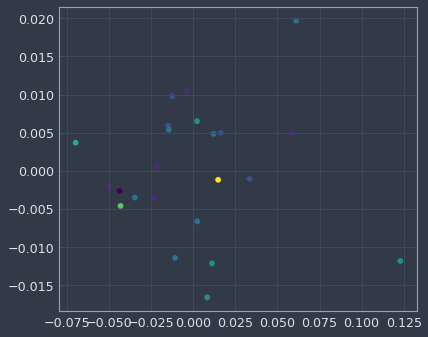

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = curvature.mean(2)
pca = PCA(n_components=2).fit_transform(X)
color = metadata['Ошибок за минуту']
plt.scatter(pca[:, 0], pca[:, 1], c=color)
plt.show()